In [95]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

## Data processing

In [96]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

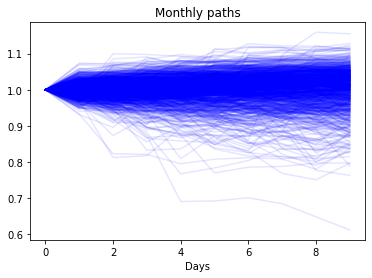

In [99]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 1000,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, freq, test_use = False):
    grid_points_dict = {"M": 28, "W": 10, "Y": 252}
    grid_points = grid_points_dict[freq]
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params, 'W')

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [98]:
windows_aug = _load_rough_bergomi(params, 'W', True)
helper = np.tile(np.arange(10)/10, [1000,1])
windows = np.concatenate([helper[:,:,None], windows_aug[:,:,None]],axis = -1)

In [86]:
import signatory
import torch

In [88]:
signatory.logsignature(torch.tensor(windows, dtype = torch.float), 10)

tensor([[ 9.0000e-01,  4.8084e-03, -3.0387e-04,  ...,  5.3627e-18,
         -1.4356e-17,  4.3257e-22],
        [ 9.0000e-01, -4.0898e-02, -3.9225e-02,  ...,  9.2163e-14,
         -2.2332e-13, -1.0163e-16],
        [ 9.0000e-01,  1.9209e-02, -1.2318e-02,  ..., -7.4530e-20,
          7.3396e-20,  1.8180e-23],
        ...,
        [ 9.0000e-01, -2.3730e-03,  9.7769e-03,  ...,  3.3912e-19,
         -5.8223e-19,  3.7830e-22],
        [ 9.0000e-01, -7.4877e-03,  2.6391e-02,  ..., -3.4558e-15,
          6.9324e-15,  1.3959e-17],
        [ 9.0000e-01, -2.5910e-02, -9.7219e-03,  ..., -9.0189e-20,
          8.7626e-19, -2.3060e-22]])

## Log-signature computing

In [102]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params, 'M')
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params, 'M')
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler_logsig = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler_logsig.fit_transform(train_logsig)

scaler_sig = MinMaxScaler(feature_range=(0.00001, 0.99999))
sig_transformed = scaler_sig.fit_transform(train_sig)

data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 
scaler = scaler_logsig

# data = sig_transformed[1:]   # 1 week forecasting 1 week 
# data_cond = sig_transformed[:-1] 
# scaler = scaler_sig

## CVAE

In [103]:
# Standard normal (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.001

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.NormalSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_normal.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated1 = model_normal.generate(data_cond)

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 1.1566
Epoch 2/10000
1/1 [==============================] - 0s 11ms/step - loss: 1.0871
Epoch 3/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0283
Epoch 4/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.9686
Epoch 5/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.9089
Epoch 6/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.8588
Epoch 7/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.7968
Epoch 8/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.7546
Epoch 9/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.7083
Epoch 10/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.6675
Epoch 11/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.6305
Epoch 12/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.5790
Epoch 13/10000
1/1 [=================

1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 203/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0358
Epoch 204/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0365
Epoch 205/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 206/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 207/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0361
Epoch 208/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0359
Epoch 209/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 210/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0363
Epoch 211/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0362
Epoch 212/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 213/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0363
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0348
Epoch 303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0345
Epoch 304/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 305/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 306/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 307/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0346
Epoch 308/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 309/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0350
Epoch 310/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 311/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0344
Epoch 312/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0349
Epoch 313/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0346
Epoch 314/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0343
Epoch 403/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 404/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0336
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0339
Epoch 406/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 407/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0336
Epoch 408/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0340
Epoch 409/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 410/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0338
Epoch 411/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 412/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 413/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0330
Epoch 503/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0323
Epoch 504/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0329
Epoch 505/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0327
Epoch 506/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0329
Epoch 507/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 508/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0328
Epoch 509/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 510/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0328
Epoch 511/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 512/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 513/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0325
Epoch 514/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 603/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 604/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 605/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 607/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 608/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 609/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 610/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 611/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 612/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0313
Epoch 613/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0310
Epoch 614/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 703/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 704/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0268
Epoch 705/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 706/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 707/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 708/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0268
Epoch 709/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0263
Epoch 710/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 711/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 712/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 713/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 714/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 803/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 804/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 805/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 806/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 808/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 809/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 810/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 811/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 812/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 813/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 814/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 903/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 904/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 905/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 906/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 907/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 908/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 909/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 910/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 911/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 912/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 913/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 914/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 1003/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 1004/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 1005/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 1006/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 1007/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 1008/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 1009/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 1010/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0157
Epoch 1011/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 1012/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 1013/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 1014/10000
1/1

1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 1199/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 1200/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 1201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1203/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 1204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1205/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 1206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1207/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 1208/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 1209/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 1210/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 1395/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 1396/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 1397/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 1398/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 1399/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 1400/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 1401/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1402/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 1403/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 1404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 1406/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 1591/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 1593/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 1594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 1595/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 1596/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 1597/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 1598/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 1599/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 1600/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 1601/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 1602/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 1787/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 1788/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 1789/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 1790/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1791/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 1792/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 1793/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 1794/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 1795/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 1796/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1797/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 1798/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1983/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 1984/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 1985/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1986/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 1987/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 1988/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 1989/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 1990/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 1991/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 1992/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1993/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 1994/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2179/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2180/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 2181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 2182/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 2183/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 2184/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 2185/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 2186/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 2187/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 2188/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2189/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2190/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 2375/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 2376/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 2378/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 2379/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 2380/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 2381/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 2382/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 2383/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 2384/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 2385/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 2386/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 2571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 2573/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 2574/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 2575/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 2576/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 2577/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 2578/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 2579/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 2580/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 2581/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 2582/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 2767/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 2768/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 2769/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2770/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 2771/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 2772/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 2773/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 2774/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 2775/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2776/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 2777/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 2778/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 2963/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2964/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2965/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 2966/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 2967/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2968/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 2969/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2970/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 2971/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 2972/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 2973/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2974/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 3159/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 3160/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 3161/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 3162/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 3163/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 3164/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 3166/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 3167/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 3168/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 3169/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 3170/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3355/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 3356/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 3357/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 3358/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 3359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 3360/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3361/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3362/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 3363/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 3364/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 3365/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 3366/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3551/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3552/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3553/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3554/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 3555/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3556/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3557/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 3558/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3559/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 3560/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 3561/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3562/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3747/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3748/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3749/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3750/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3751/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3752/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3753/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3754/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3755/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 3756/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3757/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3758/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3943/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 3944/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3945/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3946/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3947/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3948/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3949/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 3950/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3951/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3952/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 3953/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3954/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4139/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4140/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 4141/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4142/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4143/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4144/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4145/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 4146/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4147/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4148/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4149/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4150/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4335/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4336/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 4337/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4338/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4339/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4340/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4341/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4342/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4343/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 4344/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4345/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4346/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 4531/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4532/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4533/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 4534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4535/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4536/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 4537/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4538/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4539/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 4540/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4541/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4542/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4727/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4728/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 4729/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4730/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 4731/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4732/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 4733/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 4734/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4735/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4736/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4737/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4738/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4923/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4924/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4925/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 4926/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4927/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4928/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4929/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4930/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4931/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4932/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4933/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4934/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5119/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5120/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5121/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5122/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 5123/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5124/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 5125/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5126/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 5127/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5128/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5129/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5130/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5315/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5316/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 5317/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5318/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5319/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5320/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5321/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5322/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5323/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 5324/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5325/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5326/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5511/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5512/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5513/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5514/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5515/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5516/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 5517/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5518/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5519/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5520/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5521/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5522/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5707/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5708/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5710/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5712/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5714/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5715/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5716/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5717/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5718/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5903/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5904/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 5906/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 5908/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5909/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5910/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5911/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5912/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5913/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5914/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6099/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6100/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6101/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6102/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6103/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 6104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 6105/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 6106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 6107/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6108/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6109/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 6110/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6295/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6296/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6297/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6298/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6299/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6300/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6301/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6302/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6303/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6305/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 6306/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6491/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6492/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6493/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6494/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 6495/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6496/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6498/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6499/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6501/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6502/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6687/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6688/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6689/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6690/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6691/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6693/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6695/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6696/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6697/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6698/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6883/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6884/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6885/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6886/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6887/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6888/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6891/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 6892/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6893/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6894/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 7079/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7080/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7081/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7082/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 7083/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7084/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7085/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 7086/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7087/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7088/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7089/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7090/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7275/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7276/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7277/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 7278/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 7279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7280/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7281/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7282/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 7283/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 7284/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7285/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7286/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 7471/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7472/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7473/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7474/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7475/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 7476/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7477/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7478/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 7479/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7480/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7481/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 7482/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7667/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7668/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7669/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7670/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7671/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7672/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7673/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 7674/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7675/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7676/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7677/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7678/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7863/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7864/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7865/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7866/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 7868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7869/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7870/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 7872/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7873/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 7874/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8059/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8060/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 8061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8062/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8064/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8065/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8066/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 8067/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8068/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8069/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8070/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8255/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8256/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8257/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8258/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8259/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 8260/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8262/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8263/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8264/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 8265/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8266/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8451/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8452/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8453/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8454/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8456/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 8457/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8458/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8459/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8460/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8461/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8462/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8647/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8648/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8649/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8650/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8651/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8652/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8653/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8654/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 8655/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8656/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8657/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8658/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8843/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8844/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8845/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8846/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 8847/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8848/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 8849/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 8850/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 8851/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8852/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 8853/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8854/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9039/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9040/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9041/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9042/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9043/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9044/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9045/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9046/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9047/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9048/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9049/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9050/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9235/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 9236/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 9237/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 9238/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9239/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9240/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9241/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9242/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9243/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9244/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9245/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9246/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 9431/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9432/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9433/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9434/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9435/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 9436/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9437/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9438/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9439/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9440/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9441/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9442/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9627/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9628/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9629/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9630/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9631/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9632/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9633/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9634/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9635/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9636/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9637/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9638/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9823/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9824/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9825/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9826/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9827/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9828/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9829/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9830/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9831/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9832/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9833/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9834/10000
1/1 

In [104]:
generated_logsig1 = scaler.inverse_transform(normalised_generated1)
generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

# generated_sig1 = scaler.inverse_transform(normalised_generated1)
# generated_logsig1 = np.array([tosig.sig2logsig(sig, 2, order) for sig in tqdm(generated_sig1)])

In [51]:
# # Student-t (tfp)
# reload(cvae_tfp)
# sample_dim = data.shape[0]
# data_dim = data.shape[-1]
# cond_dim = data_cond.shape[-1]
# latent_dim = 8
# hidden_dim = 50
# weight = 0.003

# x_input = [data, data_cond]
# encoder = cvae_tfp.Encoder_Pseudo(data_dim, cond_dim, latent_dim, hidden_dim)
# sampler = cvae_tfp.StudentSampler(latent_dim)
# encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
# decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
# model_student = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
# model_student.compile(optimizer='adam', loss=cvae_tfp.zero_error)
# model_student.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

# normalised_generated2 = model_student.generate(data_cond)
# generated_logsig2 = scaler.inverse_transform(normalised_generated2)
# generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

In [52]:
# df,_,_ = model_student.encodersampler.encoder(x_input)
# df

In [53]:
## VAE
# generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator2.build(logsig.shape[-1])
# generator2.train(logsig, n_epochs=10000)
# normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
# generated2 = scaler.inverse_transform(normalised_generated2)
# generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

In [54]:
# CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

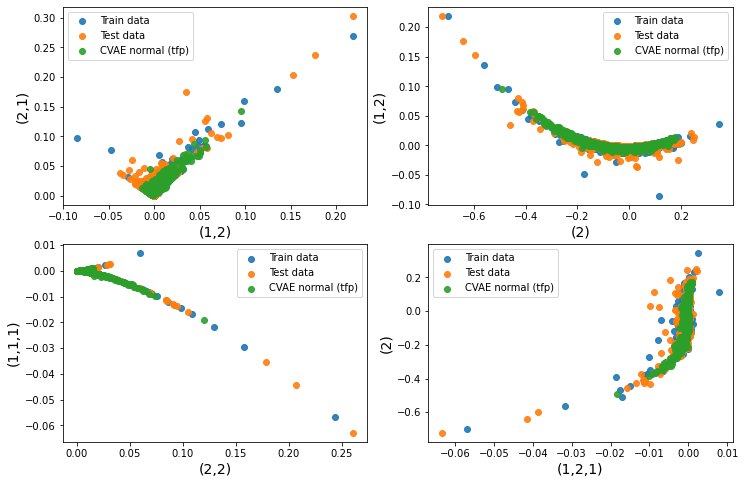

In [105]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]

set_sig = [train_sig, test_sig, generated_sig1]#, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)"]#, "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

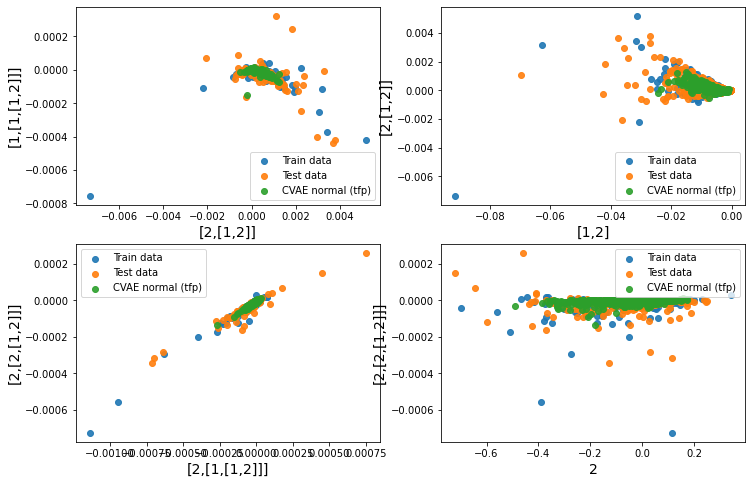

In [106]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig1]#, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)"]#, "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Evaluation

In [12]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

<module 'process_discriminator' from '../src\\process_discriminator.py'>

In [13]:
phi1 = process_discriminator.T_global(test_sig[1:], generated_sig1,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi2 = process_discriminator.T_global(test_sig[1:], generated_sig2,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi = min(phi1,phi2)

0.9999999999951377
0.9999999999964828


In [14]:
TU0 = []
TU1 = []
TU2 = []
for i in range(10):
    windows1 = _load_rough_bergomi(params)
    sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
    
    windows2 = _load_rough_bergomi(params)
    sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])

    normalised_generated1 = model_normal.generate(data_cond)
    generated_logsig1 = scaler.inverse_transform(normalised_generated1)
    generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

    normalised_generated2 = model_student.generate(data_cond)
    generated_logsig2 = scaler.inverse_transform(normalised_generated2)
    generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])
    
    result, TU = process_discriminator.test_fix(sig1[1:], sig2[1:],\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU0.append(TU)
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig1,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU1.append(TU)
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig2,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU2.append(TU)


0.9999999999951377
c: 0.012687251081145167
TU: 4.311966741932238e-05
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.00036006606468319546
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.003187642465826368
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 7.580322285871688e-06
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.00038785782698891325
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.0034877650514371084
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 1.4834959827680905e-05
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.0004598876646619843
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.004480831278007358
m: 999


KeyboardInterrupt: 

In [ ]:
TU = np.array([TU0, TU1, TU2])
label = ['TU0', 'TU1', 'TU2'] 
plt.figure(figsize = (10,4))
plt.hist(TU.T, bins = 20, density=True, histtype='bar', stacked=True, label = label)
plt.legend()
plt.show()

## From Signature to Path

In [9]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [10]:
pip = 0.001
n_pips = 5 * 10
n_points = 28
n_iterations = 100
n_organisms = 100
recovered_paths = []
for i, logsig in enumerate(generated):
    recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

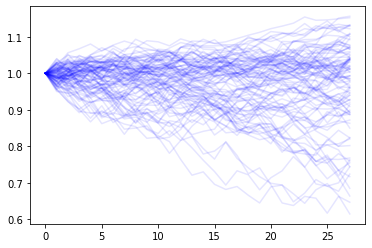

In [15]:
plt.plot(np.array(recovered_paths).T, "b", alpha=0.1)
plt.show()